# Flooding
In this notebook we are going to perform a flood frequency analysis using the Weibull and Gringorten equations. We will then fit a probability distribution to the data to estimate the magnitude of flood events with return periods greater than the number of years on record. Lastly, we will use a machine learning algorithm to predict the 10-year flood in catchments without streamflow data. 

As usual, we will start by loading the libraries we need and importing a timeseries dataset for one of the catchments in the CAMELS-GB dataset. 

In [ ]:
import os
import pandas as pd
import numpy as np
from pathlib import Path

SHARED_DATADIR = Path(os.environ["SHARED_DATA_DIR"])
DATADIR = SHARED_DATADIR / '8344e4f3-d2ea-44f5-8afa-86d2987543a9' / 'data'

# Load the data
id = '97002'
data = pd.read_csv(os.path.join(DATADIR, 'timeseries', f'CAMELS_GB_hydromet_timeseries_{id}_19701001-20150930.csv'), parse_dates=[0])
data['id'] = id
data.head()

,date,precipitation,pet,temperature,discharge_spec,discharge_vol,peti,humidity,shortwave_rad,longwave_rad,windspeed,id
0,1970-10-01,9.93,1.02,8.91,NaN,NaN,1.31,6.01,61.76,325.33,7.65,97002
1,1970-10-02,4.01,1.41,7.66,NaN,NaN,1.76,5.11,93.56,294.20,10.03,97002
2,1970-10-03,7.27,1.17,8.77,NaN,NaN,1.40,5.41,61.95,321.14,5.41,97002
3,1970-10-04,3.77,0.06,9.74,NaN,NaN,0.23,7.76,42.83,341.28,7.27,97002
4,1970-10-05,1.19,1.56,9.46,NaN,NaN,1.86,5.49,92.13,299.08,7.90,97002


In [90]:
data['water_year'] = data['date'].dt.to_period('Y-SEP')

# Get the maximum discharge as well as the number of non-NaN rows
data = data.groupby(['id', 'water_year']).agg(
    discharge_spec=('discharge_spec', 'max'),
    valid_count=('discharge_spec', 'count')
).reset_index()
data = data[(data['valid_count'] / 365.) > 0.8]
data.head()


,id,water_year,discharge_spec,valid_count
2,97002,1973,10.57,365
3,97002,1974,14.52,365
4,97002,1975,10.06,365
5,97002,1976,15.66,366
6,97002,1977,16.12,365


Now we're going to calculate the rank. For flood frequency analysis the convention is to arrange values from low to high. 

In [91]:
data['rank'] = data['discharge_spec'].rank(method='average', ascending=True)
data = data.sort_values(['rank'])
data['F_X'] = (data['rank'] / (data.shape[0] + 1))
print(data.head())
print(data.tail())

       id water_year  discharge_spec  valid_count  rank       F_X
18  97002       1989            9.80          365   1.0  0.022727
20  97002       1991            9.96          365   2.0  0.045455
4   97002       1975           10.06          365   3.0  0.068182
2   97002       1973           10.57          365   4.0  0.090909
8   97002       1979           11.06          365   5.0  0.113636
       id water_year  discharge_spec  valid_count  rank       F_X
38  97002       2009           30.20          365  39.0  0.886364
40  97002       2011           30.37          365  40.0  0.909091
42  97002       2013           33.94          365  41.0  0.931818
43  97002       2014           34.04          365  42.0  0.954545
36  97002       2007           52.30          365  43.0  0.977273


Try computing $F(X)$ using the Gringorten equation instead. Does it make a big difference? 

Once we have $F(X)$ we can estimate the average recurrence interval (i.e. return period):

In [92]:
data['T_X'] = 1 / (1 - data['F_X'])
print(data.head())
print(data.tail())

       id water_year  discharge_spec  valid_count  rank       F_X       T_X
18  97002       1989            9.80          365   1.0  0.022727  1.023256
20  97002       1991            9.96          365   2.0  0.045455  1.047619
4   97002       1975           10.06          365   3.0  0.068182  1.073171
2   97002       1973           10.57          365   4.0  0.090909  1.100000
8   97002       1979           11.06          365   5.0  0.113636  1.128205
       id water_year  discharge_spec  valid_count  rank       F_X        T_X
38  97002       2009           30.20          365  39.0  0.886364   8.800000
40  97002       2011           30.37          365  40.0  0.909091  11.000000
42  97002       2013           33.94          365  41.0  0.931818  14.666667
43  97002       2014           34.04          365  42.0  0.954545  22.000000
36  97002       2007           52.30          365  43.0  0.977273  44.000000


How can we use this to estimate the magnitude of the T-year flood (e.g. 10-year)? One way would be to pick the value with the calculated recurrence interval closest to 10. Alternatively, we can use interpolation: 

In [93]:
from scipy.interpolate import interp1d

# Create an interpolation function
interp_func = interp1d(data["T_X"], data["discharge_spec"], kind="linear", fill_value="extrapolate")

# Estimate the 10-year flood
ten_year_flood_scipy = interp_func(10)
print(f"Estimated 10-year flood (SciPy interpolation): {ten_year_flood_scipy:.2f} m³/s")

Estimated 10-year flood (SciPy interpolation): 30.29 m³/s


What if we want to obtain the flood magnitude of an event with return period of 100 years? This exceeds the length of our record, so we will need to fit a probability distribution. We will use the Gumbel distribution:

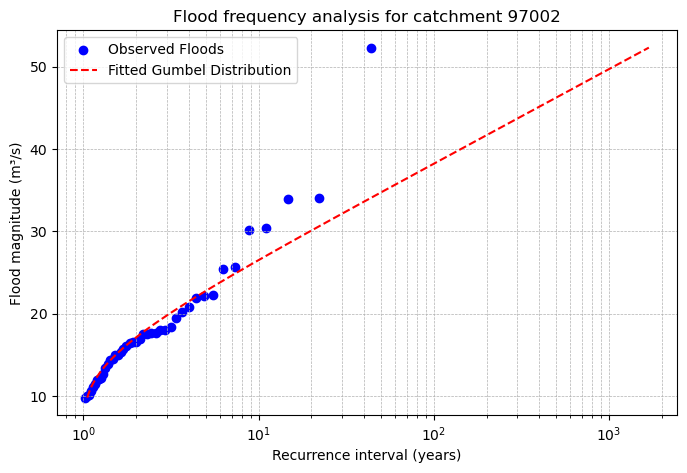

In [94]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

# Fit the Gumbel distribution
loc, scale = stats.gumbel_r.fit(data['discharge_spec'].values)

# Generate fitted Gumbel distribution
x_vals = np.linspace(data['discharge_spec'].min(), data['discharge_spec'].max(), 100)
y_vals = stats.gumbel_r.cdf(x_vals, loc=loc, scale=scale)
fitted_return_periods = 1 / (1 - y_vals)

# Plot
plt.figure(figsize=(8, 5))
plt.scatter(data["T_X"], data["discharge_spec"], label="Observed Floods", color="blue")
plt.plot(fitted_return_periods, x_vals, label="Fitted Gumbel Distribution", color="red", linestyle="--")
plt.xscale("log")  # Log scale for return periods
plt.xlabel("Recurrence interval (years)")
plt.ylabel("Flood magnitude (m³/s)")
plt.title(f'Flood frequency analysis for catchment {id}')
plt.legend()
plt.grid(which="both", linestyle="--", linewidth=0.5)
plt.show()

What do you think about the fit? There is a clear outlier with a flood magnitude greater than 50 $m^3/s$. Remember that it is perfectly possible for flood events with a larger return period to have occurred in recent decades. Now we have the fitted Gumbel distribution we can estimate the return period of a given flood. Remember the CDF of the Gumbel distribution is given by: 

$
F(X)=\exp\left(-\exp\left(-\frac{X-\mu}{\sigma}\right)\right)
$

and return period $T$ is  

$
T = \frac{1}{1-F(X)}
$

Using the above two equations we can estimate the return period of the largest flood on record as follows:

In [95]:
qmax = data['discharge_spec'].max()
F_X = np.exp(-np.exp(-(qmax - loc) / scale))
T_X = 1 / (1 - F_X)
print(T_X)

1688.641522665112


So, according to our fitted Gumbel distribution the flood event has a return period of more than 1500 years! 

We're going to try something different now. How might we estimate the flood magnitude associated with a given return period for an ungauged catchment (i.e. a catchment without river flow data)? This is a very common problem in hydrology. Over the years there have been various approaches to solve this problem, but here we're going to try and use a machine learning algorithm. To begin with, we need to calculate the flood magnitudes of our chosen return periods for all the catchments we have data about. Let's focus on the 10-year return period, which we can safely estimate from the data. First of all we're going to load all the metadata files into a single dataframe, because we will supply this data to our machine learning algorithm.

In [96]:
metadata_filenames = [
    'CAMELS_GB_climatic_attributes.csv',
    'CAMELS_GB_humaninfluence_attributes.csv',
    'CAMELS_GB_hydrogeology_attributes.csv',
    'CAMELS_GB_hydrologic_attributes.csv',
    'CAMELS_GB_hydrometry_attributes.csv',
    'CAMELS_GB_landcover_attributes.csv',
    'CAMELS_GB_soil_attributes.csv',
    'CAMELS_GB_topographic_attributes.csv'
]

# Load all metadata files into a single dataframe
from functools import reduce
metadata_list = [pd.read_csv(os.path.join(DATADIR, f)) for f in metadata_filenames]
metadata = reduce(lambda left, right: pd.merge(left, right, on='gauge_id', how='inner'), metadata_list)
metadata['gauge_id'] = metadata['gauge_id'].astype(str)

Next we're going to estimate the 10-year flood for every catchment in the CAMELS-GB dataset: 

In [97]:
def read_camels_data(id): 
    data = pd.read_csv(os.path.join(DATADIR, 'timeseries', f'CAMELS_GB_hydromet_timeseries_{id}_19701001-20150930.csv'), parse_dates=[0])
    return data 

def estimate_T_year_flood(data, T): 
    # This function copied from the code above
    data['water_year'] = data['date'].dt.to_period('Y-SEP')
    data = data.groupby(['id', 'water_year']).agg(
        discharge_spec=('discharge_spec', 'max'),
        valid_count=('discharge_spec', 'count')
    ).reset_index()
    data = data[(data['valid_count'] / 365.) > 0.8]
    data['rank'] = data['discharge_spec'].rank(method='average', ascending=True)
    data = data.sort_values(['rank'])
    data['F_X'] = (data['rank'] / (data.shape[0] + 1))
    data['T_X'] = 1 / (1 - data['F_X'])
    interp_func = interp1d(data["T_X"], data["discharge_spec"], kind="linear", fill_value="extrapolate")
    T_year_flood = interp_func(T)
    return T_year_flood

from tqdm import tqdm

catchment_ids = metadata['gauge_id'].astype(str).values 
T_year_flood_list = []
T = 10
for id in tqdm(catchment_ids): 
    data = read_camels_data(id)
    data['id'] = id
    T_year_flood = estimate_T_year_flood(data, T)
    T_year_flood_list.append(pd.DataFrame({'gauge_id': [id], f'q_{T}': T_year_flood}))

T_year_flood = pd.concat(T_year_flood_list)
T_year_flood.head()

100%|██████████| 671/671 [00:16<00:00, 40.03it/s]


,gauge_id,q_10
0,10002,20.573333
0,10003,12.962727
0,1001,23.571429
0,101002,13.086364
0,101005,16.291176


kkkNow we can merge this data with the metadata we loaded earlier. The resulting dataframe contains all the data we need to train and test our machine learning model. 

In [98]:
data = T_year_flood.merge(metadata, how='left', on='gauge_id')
print(data.head())
print(metadata.columns)

  gauge_id       q_10  p_mean  pet_mean  aridity  p_seasonality  frac_snow  \
0    10002  20.573333    2.29      1.26     0.55          -0.03       0.03   
1    10003  12.962727    2.31      1.25     0.54          -0.01       0.03   
2     1001  23.571429    2.65      1.15     0.44          -0.15       0.03   
3   101002  13.086364    2.31      1.45     0.63          -0.23       0.01   
4   101005  16.291176    2.29      1.45     0.63          -0.23       0.01   

   high_prec_freq  high_prec_dur high_prec_timing  ...  gauge_northing  \
0           13.96           1.16              son  ...          848516   
1           13.24           1.17              son  ...          830370   
2           10.98           1.11              son  ...          954915   
3           20.60           1.17              son  ...           88113   
4           20.47           1.19              son  ...           83520   

   gauge_elev    area dpsbar  elev_mean  elev_min  elev_10  elev_50  elev_90  \
0     

As with any statistical model, when we train a machine learning model we have a *dependent* variable (the variable we are trying to estimate) and a set of *independent* variables (the variables we are using to predict the dependent variable). In ML terminology the dependent variable is referred to as the *target* and the independent variables as *features*. In our case, our target is `q_10`, and our independent variables consist of columns drawn from the static catchment attributes. Note that we cannot use all of them (some are derived from streamflow timeseries data, so using them would result in data *leakage*, when information from outside the training dataset improperly influences the model, leading to overly optimistic performance during training but poor generalization to new data). 

In [99]:
target = ['q_10']
topographic_features = ['elev_mean', 'elev_min', 'elev_max', 'elev_10', 'elev_50', 'elev_90', 'dpsbar', 'area']
climatic_features = ['p_mean', 'pet_mean', 'aridity', 'p_seasonality', 'frac_snow', 'high_prec_freq', 'high_prec_dur']
landcover_features = ['dwood_perc', 'ewood_perc', 'grass_perc', 'shrub_perc', 'crop_perc', 'urban_perc', 'inwater_perc', 'bares_perc']
soil_features = ['sand_perc', 'silt_perc', 'clay_perc', 'organic_perc', 'bulkdens', 'tawc', 'porosity_hypres', 'conductivity_hypres', 'root_depth', 'soil_depth_pelletier']
hydrogeology_features = ['inter_high_perc', 'inter_mod_perc', 'inter_low_perc', 'frac_high_perc', 'frac_mod_perc', 'frac_low_perc', 'no_gw_perc', 'low_nsig_perc', 'nsig_low_perc']
features = topographic_features + climatic_features + landcover_features + soil_features + hydrogeology_features

data = data[['gauge_id'] + target + features]
data = data.dropna() # Get rid of any data rows containing NaN



/Users/smoulds/mambaforge/envs/global-hydrology-book/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/smoulds/mambaforge/envs/global-hydrology-book/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/smoulds/mambaforge/envs/global-hydrology-book/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/smoulds/mambaforge/envs/global-hydrology-book/lib/python3.12/site-packag

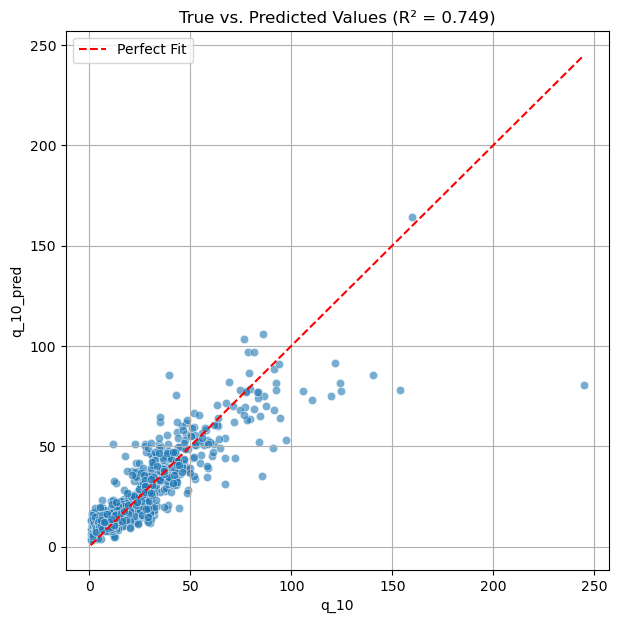

In [100]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score
import seaborn as sns

# Define features and target
X = data[features]
y = data[target]

# Initialize Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Perform 5-fold cross-validation
# cv_scores = cross_val_score(rf, X, y, cv=5, scoring='r2')
# print(cv_scores)
y_pred = cross_val_predict(rf, X, y, cv=5)
results_df = pd.DataFrame({'gauge_id': data['gauge_id'].values, 'q_10': y.values.squeeze(), 'q_10_pred': y_pred})

r2 = r2_score(results_df['q_10'], results_df['q_10_pred'])

# Plot true vs. predicted values
plt.figure(figsize=(7, 7))
sns.scatterplot(x=results_df['q_10'], y=results_df['q_10_pred'], alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r', linestyle='--', label="Perfect Fit")  # 1:1 line

# Formatting
plt.xlabel("q_10")
plt.ylabel("q_10_pred")
plt.title(f"True vs. Predicted Values (R² = {r2:.3f})")
plt.legend()
plt.grid(True)

# Show plot
plt.show()
